# Milestone P4 : Creative Extension

## Libraries

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import math
import matplotlib.image as mpimg
%matplotlib inline

## The data

In [2]:
DATA_FOLDER = 'data/'

GOWALLA_CHECKINS_DATASET = DATA_FOLDER+"G_loc_country.csv"
BRIGHTKITE_CHECKINS_DATASET = DATA_FOLDER+"B_loc_country.csv"
POPULATION_DATASET = DATA_FOLDER+"pop_per_country.csv"
BRIGHTKITE_HOME_LOCATIONS = DATA_FOLDER+"new_home_loc_B_country.csv"
GOWALLA_HOME_LOCATIONS = DATA_FOLDER+"new_home_loc_G_country.csv"
COUNTRY_CODES = DATA_FOLDER+"countrycodes.csv"
LANGUAGE_COUNTRIES = DATA_FOLDER+"language_list_by_country.xlsx"
LANGUAGE_COUNTRIES_BIS = DATA_FOLDER+"languages.xlsx"
BRIGHTKITE_TRIPS = DATA_FOLDER+"country_brightkite_trips.csv"
GOWALLA_TRIPS = DATA_FOLDER+"country_gowalla_trips.csv"
COUNTRIES_GDP = DATA_FOLDER+"countries_of_the_world.csv"
CONTINENTS = DATA_FOLDER+"conti_country.csv"

BRIGHTKITE_TRIPS_FULL = DATA_FOLDER+"brightkite_trips_full_infos.csv"
GOWALLA_TRIPS_FULL = DATA_FOLDER+"gowalla_trips_full_infos.csv"

gowalla_checkins = pd.read_csv(GOWALLA_CHECKINS_DATASET, delimiter = ',', usecols = [1,2,3,4,5])
brightkite_checkins = pd.read_csv(BRIGHTKITE_CHECKINS_DATASET, delimiter = ',', usecols = [1,2,3,4,5])
population = pd.read_csv(POPULATION_DATASET, index_col = 0, names = ['country', 'population'], header = 0)
brightkite_home_locations = pd.read_csv(BRIGHTKITE_HOME_LOCATIONS, sep =',')
gowalla_home_locations = pd.read_csv(GOWALLA_HOME_LOCATIONS, sep =',')
country_codes = pd.read_csv(COUNTRY_CODES, sep =',')
languages = pd.read_excel(LANGUAGE_COUNTRIES, names = ['country', 'language'])
languages2 = pd.read_excel(LANGUAGE_COUNTRIES_BIS, names = ['country', 'language'])
brightkite_trips = pd.read_csv(BRIGHTKITE_TRIPS)
gowalla_trips = pd.read_csv(GOWALLA_TRIPS)
brightkite_trips_full = pd.read_csv(BRIGHTKITE_TRIPS_FULL)
continents = pd.read_csv(CONTINENTS, delimiter = ',', header = 0, usecols = [1,2,4,6], names = ['country', 'code', 'region', 'continent'])
gowalla_trips_full = pd.read_csv(GOWALLA_TRIPS_FULL)
countries_gdp = pd.read_csv(COUNTRIES_GDP, delimiter = ',', usecols = [0, 8], names = ['country', 'gdp'], header = 0)

## Cleaning the data

In [3]:
population.sort_values(by = ['population'], ascending = False).head(10)

,country,population
24,china,1313973713
51,india,1095351995
127,united states,298444215
52,indonesia,245452739
15,brazil,188078227
93,pakistan,165803560
9,bangladesh,147365352
101,russia,142893540
91,nigeria,131859731
59,japan,127463611


In [4]:
brightkite_home_locations.head(3)

,user,lat,lon,country
0,0,39.747913,-104.968944,US
1,1,37.599899,-122.372723,US
2,2,39.738874,-104.954143,US


In [5]:
gowalla_home_locations.head(3)

,user,lat,lon,country
0,0,30.259167,-97.750223,US
1,1,50.381005,3.430710,FR
2,2,34.052243,-118.327641,US


In [6]:
country_codes.head()

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


In [7]:
gowalla_home_locations = pd.merge(gowalla_home_locations, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
gowalla_home_locations.drop(columns = ['country', 'Code'], inplace = True)
gowalla_home_locations.rename(columns = {'Name':'country'}, inplace = True)

brightkite_home_locations = pd.merge(brightkite_home_locations, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
brightkite_home_locations.drop(columns = ['country', 'Code'], inplace = True)
brightkite_home_locations.rename(columns = {'Name':'country'}, inplace = True)

In [8]:
gowalla_checkins = pd.merge(gowalla_checkins, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
gowalla_checkins.drop(columns = ['country', 'Code'], inplace = True)
gowalla_checkins.rename(columns = {'Name':'country'}, inplace = True)

brightkite_checkins = pd.merge(brightkite_checkins, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
brightkite_checkins.drop(columns = ['country', 'Code'], inplace = True)
brightkite_checkins.rename(columns = {'Name':'country'}, inplace = True)

In [9]:
brightkite_home_locations.head()

,user,lat,lon,country
0,0,39.747913,-104.968944,United States
1,1,37.599899,-122.372723,United States
2,2,39.738874,-104.954143,United States
3,3,37.780875,-122.406171,United States
4,4,60.174186,24.937477,Finland


In [10]:
gowalla_checkins['time'] = pd.to_datetime(gowalla_checkins['time'])
brightkite_checkins['time'] = pd.to_datetime(brightkite_checkins['time'])

In [11]:
brightkite_checkins.head()

,user,time,lat,lon,country
0,0,2010-10-17 01:48:53+00:00,39.747652,-104.992510,United States
1,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,United States
2,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,United States
3,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,United States
4,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,United States


## Step 1 : defining the geographic boundaries of our study

Before starting the study, we have to determine with which countries it would relevant to work. To estimate the quantity of data available in each country, we compute the number of homes, as defined in the replication, (i.e. users) that are located in each country. 

The point is to work only on countries in which the amount of data seems to be enough to have robust conclusions. 

In [12]:
brightkite_home_locations['country'] = brightkite_home_locations['country'].str.lower()
brightkite_checkins['country'] = brightkite_checkins['country'].str.lower()

gowalla_home_locations['country'] = gowalla_home_locations['country'].str.lower()
gowalla_checkins['country'] = gowalla_checkins['country'].str.lower()

In [13]:
brightkite_homes_per_country = brightkite_home_locations.groupby(['country']).count().sort_values(by = ['lat'], ascending = False)
brightkite_homes_per_country.drop(columns = ['lon', 'user'], inplace = True)
brightkite_homes_per_country.rename(columns={'lat':'count'}, inplace = True)
brightkite_homes_per_country.reset_index(inplace = True)

gowalla_homes_per_country = gowalla_home_locations.groupby(['country']).count().sort_values(by = ['lat'], ascending = False)
gowalla_homes_per_country.drop(columns = ['lon', 'user'], inplace = True)
gowalla_homes_per_country.rename(columns={'lat':'count'}, inplace = True)
gowalla_homes_per_country.reset_index(inplace = True)

gowalla_homes_per_country.head(10)

,country,count
0,united states,50639
1,sweden,18029
2,united kingdom,5435
3,germany,5213
4,norway,3662
5,canada,2210
6,saudi arabia,1917
7,thailand,1660
8,belgium,1569
9,australia,1311


In [14]:
brightkite_homes_per_country.head(10)

,country,count
0,united states,30669
1,united kingdom,3243
2,japan,2860
3,australia,1452
4,canada,1409
5,germany,1344
6,sweden,833
7,netherlands,789
8,italy,614
9,norway,593


In [15]:
brightkite_homes_per_country = brightkite_homes_per_country.merge(population, how = 'inner', on = ['country'])
gowalla_homes_per_country = gowalla_homes_per_country.merge(population, how = 'inner', on = ['country'])

In [16]:
brightkite_homes_per_country.head(3)

,country,count,population
0,united states,30669,298444215
1,united kingdom,3243,60609153
2,japan,2860,127463611


In [17]:
gowalla_homes_per_country.head(3)

,country,count,population
0,united states,50639,298444215
1,sweden,18029,9016596
2,united kingdom,5435,60609153


The number of home per country is normalized by the population of the country. 

In [18]:
brightkite_homes_per_country['count_normalized'] = brightkite_homes_per_country['count']/brightkite_homes_per_country['population']
gowalla_homes_per_country['count_normalized'] = gowalla_homes_per_country['count']/gowalla_homes_per_country['population']

In [19]:
brightkite_homes_per_country.sort_values(by = 'count_normalized', ascending = False).head(10)

,country,count,population,count_normalized
9,norway,593,4610820,0.000129
0,united states,30669,298444215,0.000103
6,sweden,833,9016596,0.000092
40,luxembourg,40,474413,0.000084
3,australia,1452,20264082,0.000072
12,finland,367,5231372,0.000070
1,united kingdom,3243,60609153,0.000054
7,netherlands,789,16491461,0.000048
4,canada,1409,33098932,0.000043
36,estonia,53,1324333,0.000040


In [20]:
gowalla_homes_per_country.sort_values(by = 'count_normalized', ascending = False).head(10)

,country,count,population,count_normalized
1,sweden,18029,9016596,0.002000
4,norway,3662,4610820,0.000794
29,luxembourg,172,474413,0.000363
0,united states,50639,298444215,0.000170
8,belgium,1569,10379067,0.000151
11,switzerland,994,7523934,0.000132
17,denmark,607,5450661,0.000111
2,united kingdom,5435,60609153,0.000090
21,singapore,392,4492150,0.000087
10,netherlands,1259,16491461,0.000076


Let's say that we will only work with countries which count_normalized value is higher to a certain rate. 

In [21]:
rate = 0.00001
brightkite_countries = brightkite_homes_per_country[brightkite_homes_per_country.count_normalized >= rate]
gowalla_countries = gowalla_homes_per_country[gowalla_homes_per_country.count_normalized >= rate]
print('With this rate,', len(brightkite_countries), 'countries are taken in the study for the Brightkite dataset.')
print('With this rate,', len(gowalla_countries), 'countries are taken in the study for the Gowalla dataset.')

With this rate, 28 countries are taken in the study for the Brightkite dataset.
With this rate, 38 countries are taken in the study for the Gowalla dataset.


In [22]:
countries = pd.merge(brightkite_countries, gowalla_countries, how = 'inner', on = ['country'], suffixes=('_brightkite', '_gowalla')) # countries that are ok both for the Gowalla and Brightkite datasets
print('With this rate,', len(countries), 'countries are taken in the study for both datasets.')

With this rate, 25 countries are taken in the study for both datasets.


In [23]:
countries.head(5)

,country,count_brightkite,population_brightkite,count_normalized_brightkite,count_gowalla,population_gowalla,count_normalized_gowalla
0,united states,30669,298444215,0.000103,50639,298444215,0.000170
1,united kingdom,3243,60609153,0.000054,5435,60609153,0.000090
2,australia,1452,20264082,0.000072,1311,20264082,0.000065
3,canada,1409,33098932,0.000043,2210,33098932,0.000067
4,germany,1344,82422299,0.000016,5213,82422299,0.000063


## Distance from home

In [31]:
gowalla_home_locations.rename(columns={'lat':'home_lat','lon':'home_lon'}, inplace = True)
brightkite_home_locations.rename(columns={'lat':'home_lat','lon':'home_lon'}, inplace = True)

In [32]:
gowalla_checkins = pd.merge(gowalla_checkins, gowalla_home_locations, how = 'left', on = ['user'], suffixes = ('_checkin', '_home'))
brightkite_checkins = pd.merge(brightkite_checkins, brightkite_home_locations, how = 'left', on = ['user'], suffixes = ('_checkin', '_home'))

In [33]:
import haversine as hvrs

In [34]:
def distance_from_home(row):
    '''computes the distance between the check-in and the user's home'''
    lat1 = row['lat']
    lat2 = row['home_lat']
    long1 = row['lon']
    long2 = row['home_lon']
    return(hvrs.haversine((lat1, long1), (lat2, long2)))

In [35]:
gowalla_checkins['distance_from_home'] = gowalla_checkins.apply(lambda row: distance_from_home(row), axis = 1)
brightkite_checkins['distance_from_home'] = brightkite_checkins.apply(lambda row: distance_from_home(row), axis = 1)

In [36]:
gowalla_checkins.head(3)

,user,time,lat,lon,country_checkin,home_lat,home_lon,country_home,distance_from_home
0,0,2010-10-19 23:55:27+00:00,30.235909,-97.795140,united states,30.259167,-97.750223,united states,5.030254
1,0,2010-10-18 22:17:43+00:00,30.269103,-97.749395,united states,30.259167,-97.750223,united states,1.107683
2,0,2010-10-17 23:42:03+00:00,30.255731,-97.763386,united states,30.259167,-97.750223,united states,1.320713


In [37]:
distance = 200 #km
gowalla_far_checkins = gowalla_checkins[gowalla_checkins.distance_from_home >= distance]
brightkite_far_checkins = brightkite_checkins[brightkite_checkins.distance_from_home >= distance]
len(gowalla_far_checkins), len(brightkite_far_checkins)

(942618, 511709)

In [38]:
gowalla_far_checkins.head(3)

,user,time,lat,lon,country_checkin,home_lat,home_lon,country_home,distance_from_home
10,0,2010-10-12 00:21:28+00:00,40.643885,-73.782806,united states,30.259167,-97.750223,united states,2447.558851
11,0,2010-10-11 20:21:20+00:00,40.741374,-73.988105,united states,30.259167,-97.750223,united states,2435.235803
12,0,2010-10-11 20:20:42+00:00,40.741388,-73.989455,united states,30.259167,-97.750223,united states,2435.130291


In [39]:
gowalla_far_checkins_per_country = gowalla_far_checkins.groupby(['country_home']).count().sort_values(by = 'user', ascending = False)
gowalla_far_checkins_per_country.rename(columns = {'user':'count'}, inplace = True)
gowalla_far_checkins_per_country.drop(gowalla_far_checkins_per_country.columns.difference(['count']), 1, inplace=True)
gowalla_far_checkins_per_country.head(10)

,count
country_home,
united states,634893
sweden,103646
germany,39033
united kingdom,29169
norway,23863
canada,15475
saudi arabia,12489
australia,7229
france,6170


In [40]:
brightkite_far_checkins_per_country = brightkite_far_checkins.groupby(['country_home']).count().sort_values(by = 'user', ascending = False)
brightkite_far_checkins_per_country.rename(columns = {'user':'count'}, inplace = True)
brightkite_far_checkins_per_country.drop(brightkite_far_checkins_per_country.columns.difference(['count']), 1, inplace=True)
brightkite_far_checkins_per_country.head(10)

,count
country_home,
united states,358789
japan,41834
united kingdom,15637
australia,10371
germany,10175
sweden,8575
canada,7780
france,6999
spain,4893


# Step 2 : countries where users travelled 

# Languages

In [41]:
languages2['country'] = languages2['country'].str.strip()
languages2['country'] = languages2['country'].str.lower()
languages2['language'] = languages2['language'].str.lower()

In [42]:
languages2.head(20)

,country,language
0,afghanistan,dari (official) 77% (dari functions as the lin...
1,albania,albanian 98.8% (official - derived from tosk d...
2,algeria,"arabic (official), french (lingua franca), ber..."
3,andorra,"catalan (official), french, castilian, portuguese"
4,angola,"portuguese 71.2% (official), umbundu 23%, kiko..."
5,antigua and barbuda,"english (official), antiguan creole"
6,argentina,"spanish (official), italian, english, german, ..."
7,armenia,"armenian (official) 97.9%, kurdish (spoken by ..."
8,australia,"english 72.7%, mandarin 2.5%, arabic 1.4%, can..."
9,austria,"german (official nationwide) 88.6%, turkish 2...."


In [43]:
# Only keep the first word (either separated by a comma or a space from other words)
languages2['language'] = languages2['language'].str.partition(' ')[0]
languages2['language'] = languages2['language'].str.partition(',')[0]

In [44]:
languages2.head(20)

,country,language
0,afghanistan,dari
1,albania,albanian
2,algeria,arabic
3,andorra,catalan
4,angola,portuguese
5,antigua and barbuda,english
6,argentina,spanish
7,armenia,armenian
8,australia,english
9,austria,german


In [45]:
languages2[languages2.country == 'belgium']

,country,language
16,belgium,dutch


In [46]:
languages2[languages2.language.str.contains('french') == True]

,country,language
18,benin,french
26,burkina faso,french
33,central african republic,french
34,chad,french
39,"congo, democratic republic of the",french
40,"congo, republic of",french
42,côte d'ivoire,french
48,djibouti,french
62,france,french
63,gabon,french


In [47]:
gowalla_trips = pd.merge(gowalla_trips, languages2, how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_trips.drop(columns = 'country', inplace = True)
gowalla_trips.rename(columns = {'language':'language_home'}, inplace = True)

gowalla_trips = pd.merge(gowalla_trips, languages2, how = 'left', left_on = 'country_checkin', right_on = 'country')
gowalla_trips.drop(columns = 'country', inplace = True)
gowalla_trips.rename(columns = {'language':'language_checkin'}, inplace = True)

gowalla_trips.head()

,country_home,country_checkin,user,language_home,language_checkin
0,afghanistan,belgium,1,dari,dutch
1,afghanistan,united arab emirates,1,dari,arabic
2,afghanistan,united kingdom,1,dari,english
3,albania,hungary,1,albanian,hungarian
4,albania,spain,1,albanian,castilian


In [48]:
brightkite_trips = pd.merge(brightkite_trips, languages2, how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_trips.drop(columns = 'country', inplace = True)
brightkite_trips.rename(columns = {'language':'language_home'}, inplace = True)

brightkite_trips = pd.merge(brightkite_trips, languages2, how = 'left', left_on = 'country_checkin', right_on = 'country')
brightkite_trips.drop(columns = 'country', inplace = True)
brightkite_trips.rename(columns = {'language':'language_checkin'}, inplace = True)

brightkite_trips.head()

,country_home,country_checkin,user,language_home,language_checkin
0,algeria,france,1,arabic,french
1,angola,portugal,1,portuguese,portuguese
2,argentina,benin,2,spanish,french
3,argentina,brazil,1,spanish,portuguese
4,argentina,czech republic,3,spanish,greek


In [42]:
def same_language(row):
    language_home = row['language_home']
    language_checkin = row['language_checkin']
    if(language_home == language_checkin):
        return(1)
    else:
        return(0)

In [43]:
gowalla_trips['same_language'] = gowalla_trips.apply(lambda row : same_language(row), axis = 1)
brightkite_trips['same_language'] = brightkite_trips.apply(lambda row : same_language(row), axis = 1)

In [44]:
gowalla_trips.head(20)

,country_home,country_checkin,user,language_home,language_checkin,same_language
0,afghanistan,belgium,1,dari,dutch,0
1,afghanistan,united arab emirates,1,dari,arabic,0
2,afghanistan,united kingdom,1,dari,english,0
3,albania,hungary,1,albanian,hungarian,0
4,albania,spain,1,albanian,castilian,0
5,argentina,australia,1,spanish,english,0
6,argentina,chile,2,spanish,spanish,1
7,argentina,uruguay,1,spanish,spanish,1
8,australia,argentina,1,english,spanish,0
9,australia,bahamas,1,english,azerbaijani,0


In [45]:
brightkite_trips.head()

,country_home,country_checkin,user,language_home,language_checkin,same_language
0,algeria,france,1,arabic,french,0
1,angola,portugal,1,portuguese,portuguese,1
2,argentina,benin,2,spanish,french,0
3,argentina,brazil,1,spanish,portuguese,0
4,argentina,czech republic,3,spanish,greek,0


The distance between two countries is defined as the mean between the distances done by the users between the two countries (distance between the check-in in the foreign country and the home location).   

In [46]:
gowalla_far_checkins[(gowalla_far_checkins.country_home == 'united states') & (gowalla_far_checkins.country_checkin == 'brazil')].distance_from_home.mean()

9149.11447292096

In [47]:
def gowalla_distance_between_countries(row):
    '''returns the distance between 2 countries as defined previusly (Gowalla dataset)'''
    country_home = row['country_home']
    country_checkin = row['country_checkin']
    distance = gowalla_far_checkins[(gowalla_far_checkins.country_home == country_home) & 
                                    (gowalla_far_checkins.country_checkin == country_checkin)].distance_from_home.mean()
    return(distance)

In [48]:
def brightkite_distance_between_countries(row):
    '''returns the distance between 2 countries as defined previusly (Brightkite dataset)'''
    country_home = row['country_home']
    country_checkin = row['country_checkin']
    distance = brightkite_far_checkins[(brightkite_far_checkins.country_home == country_home) & 
                                    (brightkite_far_checkins.country_checkin == country_checkin)].distance_from_home.mean()
    return(distance)

In [ ]:
gowalla_trips['distance'] = gowalla_trips.apply(lambda row: gowalla_distance_between_countries(row), axis = 1)

In [ ]:
brightkite_trips['distance'] = brightkite_trips.apply(lambda row: brightkite_distance_between_countries(row), axis = 1)

In [ ]:
gowalla_trips.sample(5)

In [ ]:
# we will include the difference of GDP between the departure and arrival countries to see (thanks to a logistic regression)
# if it is a factor for people to move. 

In [49]:
countries_gdp['country'] = countries_gdp['country'].str.lower()
countries_gdp['country'] = countries_gdp['country'].str.strip()
countries_gdp.head(3) # gdp per capita

,country,gdp
0,afghanistan,700.0
1,albania,4500.0
2,algeria,6000.0


In [50]:
gowalla_trips = pd.merge(gowalla_trips, countries_gdp, how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_trips = pd.merge(gowalla_trips, countries_gdp, how = 'left', left_on = 'country_checkin', right_on = 'country', suffixes=('','_arrival'))
gowalla_trips['gdp_difference'] = gowalla_trips['gdp'] - gowalla_trips['gdp_arrival']
gowalla_trips.drop(columns = ['country', 'gdp', 'country_arrival', 'gdp_arrival'], inplace = True)

brightkite_trips = pd.merge(brightkite_trips, countries_gdp, how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_trips = pd.merge(brightkite_trips, countries_gdp, how = 'left', left_on = 'country_checkin', right_on = 'country', suffixes=('','_arrival'))
brightkite_trips['gdp_difference'] = brightkite_trips['gdp'] - brightkite_trips['gdp_arrival']
brightkite_trips.drop(columns = ['country', 'gdp', 'country_arrival', 'gdp_arrival'], inplace = True)

In [51]:
brightkite_trips.sample(3)

,country_home,country_checkin,user,language_home,language_checkin,gdp_difference
1954,turkey,italy,2,turkish,italian,-20000.0
584,france,portugal,9,french,portuguese,9600.0
1393,norway,switzerland,11,norwegian,german,5100.0


In [52]:
gowalla_trips.sample(3)

,country_home,country_checkin,user,language_home,language_checkin,gdp_difference
86,austria,russian federation,2,german,NaN,NaN
1119,"macedonia, the former yugoslav republic of",croatia,1,NaN,croatian,NaN
2249,united states,indonesia,30,english,bahasa,34600.0


# Polynomial regression

In [58]:
gowalla_trips_full.head()

,Unnamed: 0,country_home,country_checkin,user,language_home,language_checkin,same_language,distance,gdp_difference
0,0,afghanistan,belgium,1,dari,dutch,0,5400.722789,-28400.0
1,1,afghanistan,united arab emirates,1,dari,arabic,0,1684.946973,-22500.0
2,2,afghanistan,united kingdom,1,dari,english,0,5707.038313,-27000.0
3,3,albania,hungary,1,albanian,hungarian,0,695.217690,-9400.0
4,4,albania,spain,1,albanian,castilian,0,2143.897129,-17500.0


In [53]:
gowalla_trips_full_reg = gowalla_trips_full.copy()
gowalla_trips_full_reg['distance'] = (gowalla_trips_full_reg['distance'] - gowalla_trips_full_reg['distance'].mean())/gowalla_trips_full_reg['distance'].std()
gowalla_trips_full_reg['gdp_difference'] = (gowalla_trips_full_reg['gdp_difference'] - gowalla_trips_full_reg['gdp_difference'].mean())/gowalla_trips_full_reg['gdp_difference'].std()

In [54]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='user ~  distance + gdp_difference + C(same_language) \
              + I(distance**2) + I(gdp_difference**2) + I(distance**3) + I(gdp_difference**3) \
              + I(distance**4) + I(gdp_difference**4) + I(distance**5) + I(gdp_difference**5)', data=gowalla_trips_full_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   user   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.838
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           2.10e-07
Time:                        22:35:51   Log-Likelihood:                -10639.
No. Observations:                1953   AIC:                         2.130e+04
Df Residuals:                    1941   BIC:                         2.137e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 16

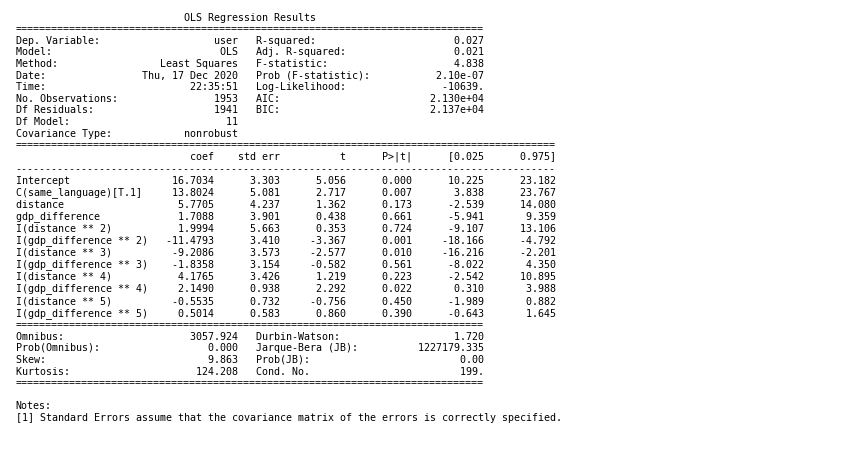

In [55]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
#plt.savefig('polynomial_reg_gowalla.png')

In [56]:
brightkite_trips_full_reg = brightkite_trips_full.copy()
brightkite_trips_full_reg['distance'] = (brightkite_trips_full_reg['distance'] - brightkite_trips_full_reg['distance'].mean())/brightkite_trips_full_reg['distance'].std()
brightkite_trips_full_reg['gdp_difference'] = (brightkite_trips_full_reg['gdp_difference'] - brightkite_trips_full_reg['gdp_difference'].mean())/brightkite_trips_full_reg['gdp_difference'].std()

In [57]:
mod = smf.ols(formula='user ~  distance + gdp_difference + C(same_language) \
              + I(distance**2) + I(gdp_difference**2) + I(distance**3) + I(gdp_difference**3) \
              + I(distance**4) + I(gdp_difference**4) + I(distance**5) + I(gdp_difference**5)', data=brightkite_trips_full_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   user   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.022
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           9.24e-08
Time:                        22:35:52   Log-Likelihood:                -9412.0
No. Observations:                1916   AIC:                         1.885e+04
Df Residuals:                    1904   BIC:                         1.891e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11

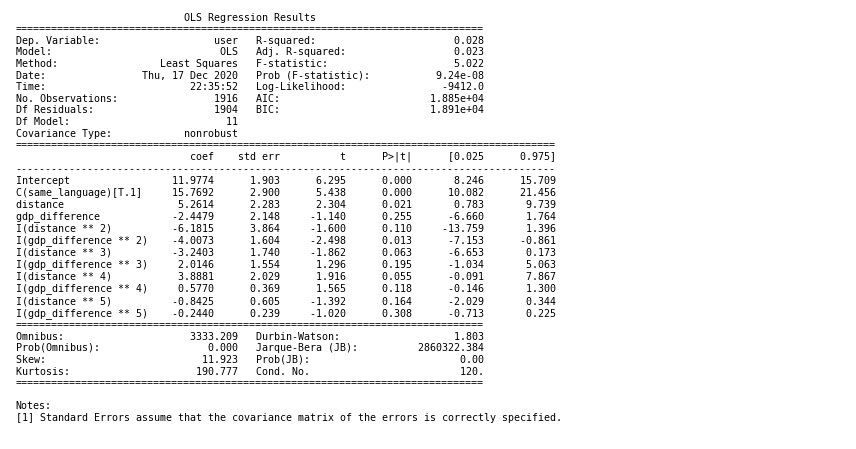

In [58]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
#plt.savefig('polynomial_reg_brightkite.png')

# Comparison United-States vs Europe

- Average distance 
- Part of the population going out of the country to travel 
- Number of visited country per traveller  

In [59]:
continents['country'] = continents['country'].str.lower()
continents['region'] = continents['region'].str.lower()
continents['continent'] = continents['continent'].str.lower()
continents.head()

,country,code,region,continent
0,afghanistan,AFG,southern asia,asia
1,åland islands,ALA,northern europe,europe
2,albania,ALB,southern europe,europe
3,algeria,DZA,northern africa,africa
4,american samoa,ASM,polynesia,oceania


In [60]:
gowalla_trips_full = pd.merge(gowalla_trips_full, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_trips_full.drop(columns = ['country'], inplace = True)
gowalla_trips_full.rename(columns = {'continent':'continent_home'}, inplace = True)
gowalla_trips_full.head()

,Unnamed: 0,country_home,country_checkin,user,language_home,language_checkin,same_language,distance,gdp_difference,continent_home
0,0,afghanistan,belgium,1,dari,dutch,0,5400.722789,-28400.0,asia
1,1,afghanistan,united arab emirates,1,dari,arabic,0,1684.946973,-22500.0,asia
2,2,afghanistan,united kingdom,1,dari,english,0,5707.038313,-27000.0,asia
3,3,albania,hungary,1,albanian,hungarian,0,695.217690,-9400.0,europe
4,4,albania,spain,1,albanian,castilian,0,2143.897129,-17500.0,europe


In [61]:
brightkite_trips_full = pd.merge(brightkite_trips_full, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_trips_full.drop(columns = ['country'], inplace = True)
brightkite_trips_full.rename(columns = {'continent':'continent_home'}, inplace = True)
brightkite_trips_full.head()

,Unnamed: 0,country_home,country_checkin,user,language_home,language_checkin,same_language,distance,gdp_difference,continent_home
0,0,algeria,france,1,arabic,french,0,1511.896058,-21600.0,africa
1,1,angola,portugal,1,portuguese,portuguese,1,5889.419408,-16100.0,africa
2,2,argentina,benin,2,spanish,french,0,8214.132012,10100.0,south america
3,3,argentina,brazil,1,spanish,portuguese,0,3264.244477,3600.0,south america
4,4,argentina,czech republic,3,spanish,greek,0,11811.431790,-4500.0,south america


## 1. Average distance when people leave their country

In [62]:
gowalla_trips_full.sample(5)

,Unnamed: 0,country_home,country_checkin,user,language_home,language_checkin,same_language,distance,gdp_difference,continent_home
1534,1476,portugal,viet nam,1,portuguese,NaN,0,11189.871728,NaN,europe
283,283,canada,united kingdom,31,english,english,1,6046.823725,2100.0,north america
1050,992,japan,chile,1,japanese,spanish,0,17227.139285,18300.0,asia
1328,1270,norway,argentina,1,norwegian,spanish,0,12248.351784,26600.0,europe
1138,1080,latvia,estonia,3,latvian,estonian,0,279.792607,-2100.0,europe


In [63]:
gowalla_trips_full['total_distance'] = gowalla_trips_full['user']*gowalla_trips_full['distance']
brightkite_trips_full['total_distance'] = gowalla_trips_full['user']*gowalla_trips_full['distance']

In [64]:
total_distance_us = gowalla_trips_full[gowalla_trips_full.country_home == 'united states'].total_distance.sum() + brightkite_trips_full[brightkite_trips_full.country_home == 'united states'].total_distance.sum()
total_users_us = gowalla_trips_full[gowalla_trips_full.country_home == 'united states'].user.sum() + brightkite_trips_full[brightkite_trips_full.country_home == 'united states'].user.sum()
print('Average distance when American people travel far from home and leave their country:', total_distance_us/total_users_us, 'km')

Average distance when American people travel far from home and leave their country: 7369.5230730897565 km


In [65]:
total_distance_eu = gowalla_trips_full[gowalla_trips_full.continent_home == 'europe'].total_distance.sum() + brightkite_trips_full[brightkite_trips_full.continent_home == 'europe'].total_distance.sum()
total_users_eu = gowalla_trips_full[gowalla_trips_full.continent_home == 'europe'].user.sum() + brightkite_trips_full[brightkite_trips_full.continent_home == 'europe'].user.sum()
print('Average distance when European people travel far from home and leave their country:', total_distance_eu/total_users_eu, 'km')

Average distance when European people travel far from home and leave their country: 3155.6342079378787 km


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


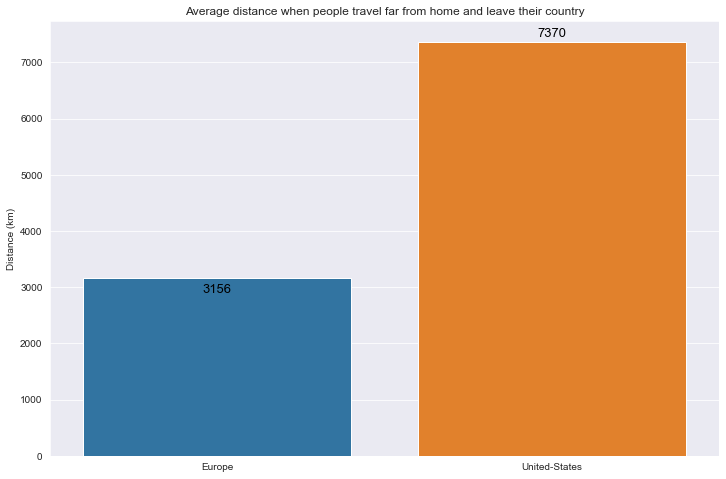

In [66]:
import seaborn as sns
x = ['Europe', 'United-States']
y = [total_distance_eu/total_users_eu, total_distance_us/total_users_us]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set(title = 'Average distance when people travel far from home and leave their country', ylabel='Distance (km)')
fig.text(0, 2900, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 7450, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()

In [67]:
gowalla_distance_us = gowalla_trips_full[gowalla_trips_full.country_home == 'united states'].total_distance.sum() 
gowalla_users_us = gowalla_trips_full[gowalla_trips_full.country_home == 'united states'].user.sum() 
print('Average distance when American people travel far from home:', gowalla_distance_us/gowalla_users_us, 'km (Gowalla)')

Average distance when American people travel far from home: 7141.234398740012 km (Gowalla)


In [68]:
brightkite_distance_us = brightkite_trips_full[brightkite_trips_full.country_home == 'united states'].total_distance.sum()
brightkite_users_us = brightkite_trips_full[brightkite_trips_full.country_home == 'united states'].user.sum()
print('Average distance when American people travel far from home:', brightkite_distance_us/brightkite_users_us, 'km (Brightkite)')

Average distance when American people travel far from home: 7591.646599037612 km (Brightkite)


In [69]:
gowalla_distance_eu = gowalla_trips_full[gowalla_trips_full.continent_home == 'europe'].total_distance.sum() 
gowalla_users_eu = gowalla_trips_full[gowalla_trips_full.continent_home == 'europe'].user.sum() 
print('Average distance when European people travel far from home:', gowalla_distance_eu/gowalla_users_eu, 'km (Gowalla)')

Average distance when European people travel far from home: 2372.1524329358645 km (Gowalla)


In [70]:
brightkite_distance_eu = brightkite_trips_full[brightkite_trips_full.continent_home == 'europe'].total_distance.sum()
brightkite_users_eu = brightkite_trips_full[brightkite_trips_full.continent_home == 'europe'].user.sum()
print('Average distance when European people travel far from home:', brightkite_distance_eu/brightkite_users_eu, 'km (Brightkite)')

Average distance when European people travel far from home: 5178.994908428517 km (Brightkite)


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


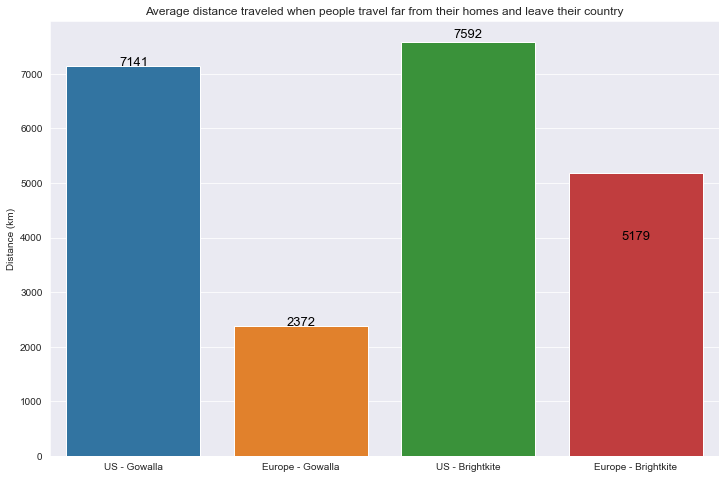

In [71]:
y=[gowalla_distance_us/gowalla_users_us,
   gowalla_distance_eu/gowalla_users_eu,
   brightkite_distance_us/brightkite_users_us,
   brightkite_distance_eu/brightkite_users_eu]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set(title='Average distance traveled when people travel far from their homes and leave their country', ylabel = 'Distance (km)')
fig.text(0, 7152, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 2381, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 7667, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 3965, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()

In [72]:
continents.head()

,country,code,region,continent
0,afghanistan,AFG,southern asia,asia
1,åland islands,ALA,northern europe,europe
2,albania,ALB,southern europe,europe
3,algeria,DZA,northern africa,africa
4,american samoa,ASM,polynesia,oceania


In [73]:
gowalla_far_checkins = pd.merge(gowalla_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_far_checkins.drop(columns = ['country'], inplace = True)
gowalla_far_checkins.rename(columns = {'continent':'continent_home'}, inplace = True)
gowalla_far_checkins.sample(5)

,user,time,lat,lon,country_checkin,home_lat,home_lon,country_home,distance_from_home,continent_home
663693,72826,2010-03-15 04:07:59+00:00,33.941829,-118.399572,united states,40.764522,-73.985348,united states,3955.263477,north america
87104,1519,2010-10-06 12:36:39+00:00,55.474393,-5.711881,united kingdom,45.390185,-75.672877,canada,4859.758340,north america
714977,97069,2010-10-06 18:17:05+00:00,42.592497,-5.578473,spain,39.559715,2.629274,spain,765.737266,europe
649964,67732,2010-06-15 01:33:46+00:00,32.731877,-117.201977,united states,30.241941,-97.703378,united states,1866.790971,north america
165782,3395,2010-07-10 00:39:33+00:00,37.797625,-122.406600,united states,33.126866,-96.670430,united states,2379.923094,north america


In [74]:
gowalla_far_checkins.sample(5)

,user,time,lat,lon,country_checkin,home_lat,home_lon,country_home,distance_from_home,continent_home
513561,35208,2010-01-30 03:43:15+00:00,32.503760,-85.024309,united states,41.903169,-87.668193,united states,1070.918699,north america
617801,56063,2010-08-13 17:15:29+00:00,40.041989,-76.308442,united states,34.231583,-119.222375,united states,3821.092489,north america
47807,695,2010-06-23 01:38:24+00:00,37.422628,-122.085679,united states,39.674267,-104.982851,united states,1505.849899,north america
339258,13624,2010-07-18 16:27:38+00:00,33.094274,-96.820707,united states,38.844223,-104.907493,united states,967.973516,north america
589420,49300,2010-09-16 22:23:53+00:00,39.747549,-104.994771,united states,32.741959,-97.341061,united states,1037.377120,north america


In [75]:
brightkite_far_checkins = pd.merge(brightkite_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_far_checkins.drop(columns = ['country'], inplace = True)
brightkite_far_checkins.rename(columns = {'continent':'continent_home'}, inplace = True)
brightkite_far_checkins.head()

,user,time,lat,lon,country_checkin,home_lat,home_lon,country_home,distance_from_home,continent_home
0,0,2010-05-07 22:34:54+00:00,37.615223,-122.389979,united states,39.747913,-104.968944,united states,1528.157039,north america
1,0,2010-05-07 21:10:40+00:00,37.579361,-122.346108,united states,39.747913,-104.968944,united states,1525.404238,north america
2,0,2010-05-07 18:18:37+00:00,37.578379,-122.347524,united states,39.747913,-104.968944,united states,1525.552344,north america
3,0,2010-05-07 18:13:36+00:00,37.579361,-122.346108,united states,39.747913,-104.968944,united states,1525.404238,north america
4,0,2010-05-07 02:46:58+00:00,37.785078,-122.404998,united states,39.747913,-104.968944,united states,1524.877576,north america


In [76]:
gowalla_us_dist = gowalla_far_checkins[(gowalla_far_checkins.country_home == 'united states') & (gowalla_far_checkins.country_home != gowalla_far_checkins.country_checkin)].distance_from_home.mean()

In [77]:
gowalla_eu_dist = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'europe') & (gowalla_far_checkins.country_home != gowalla_far_checkins.country_checkin)].distance_from_home.mean()

In [78]:
brightkite_us_dist = brightkite_far_checkins[(brightkite_far_checkins.country_home == 'united states')& (brightkite_far_checkins.country_home != brightkite_far_checkins.country_checkin)].distance_from_home.mean()

In [79]:
brightkite_eu_dist = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'europe') & (brightkite_far_checkins.country_home != brightkite_far_checkins.country_checkin)].distance_from_home.mean()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


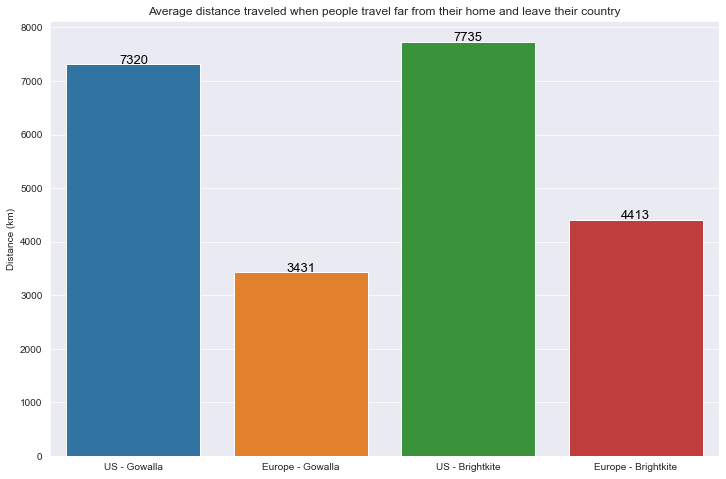

In [80]:
y=[gowalla_us_dist, gowalla_eu_dist, brightkite_us_dist, brightkite_eu_dist]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set(title='Average distance traveled when people travel far from their home and leave their country', ylabel = 'Distance (km)')
fig.text(0, 7330, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 3441, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 7745, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 4426, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("distance_eu_vs_us.png")

## 1-bis Average distance for d>200 km but not always out of the country

In [81]:
gowalla_us_dist_2 = gowalla_far_checkins[gowalla_far_checkins.country_home == 'united states'].distance_from_home.mean()

In [82]:
gowalla_eu_dist_2 = gowalla_far_checkins[gowalla_far_checkins.continent_home == 'europe'].distance_from_home.mean()

In [83]:
brightkite_us_dist_2 = brightkite_far_checkins[brightkite_far_checkins.country_home == 'united states'].distance_from_home.mean()

In [84]:
brightkite_eu_dist_2 = brightkite_far_checkins[brightkite_far_checkins.continent_home == 'europe'].distance_from_home.mean()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


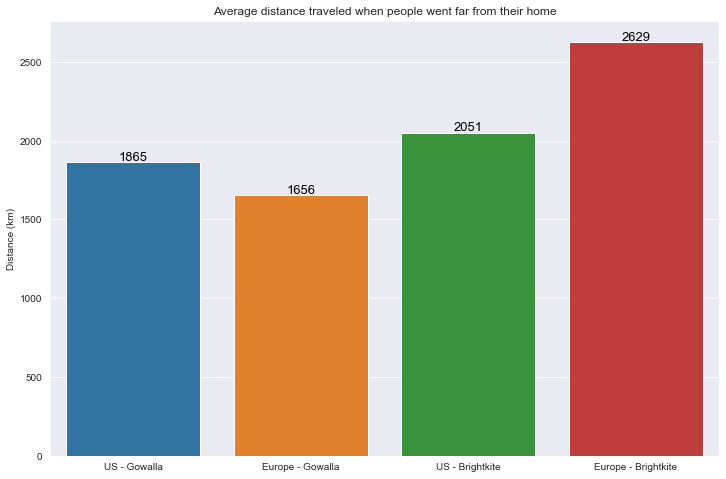

In [85]:
y=[gowalla_us_dist_2, gowalla_eu_dist_2, brightkite_us_dist_2, brightkite_eu_dist_2]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set(title='Average distance traveled when people went far from their home', ylabel = 'Distance (km)')
fig.text(0, 1875, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 1664, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 2061, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 2635, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("distance_wihout_leaving_country_eu_vs_us.png")

## 2. Part of the population going out of the country to travel 

In [90]:
gowalla_us_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.country_home == 'united states')].user.nunique()
gowalla_us_total = gowalla_far_checkins[(gowalla_far_checkins.country_home == 'united states')].user.nunique()
print('Part of the US population going out of the country to travel:',100*gowalla_us_travel_out_of_country/gowalla_us_total,'% (Gowalla)')

Part of the US population going out of the country to travel: 11.987769864648197 % (Gowalla)


In [91]:
brightkite_us_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.country_home == 'united states')].user.nunique()
brightkite_us_total = brightkite_far_checkins[(brightkite_far_checkins.country_home == 'united states')].user.nunique()
print('Part of the US population going out of the country to travel:',100*brightkite_us_travel_out_of_country/brightkite_us_total,'% (Brightkite)')

Part of the US population going out of the country to travel: 23.396560038579008 % (Brightkite)


In [92]:
gowalla_eu_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.continent_home == 'europe')].user.nunique()
gowalla_eu_total = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'europe')].user.nunique()
print('Part of the European population going out of the country to travel:',100*gowalla_eu_travel_out_of_country/gowalla_eu_total,'% (Gowalla)')

Part of the European population going out of the country to travel: 52.98789712556732 % (Gowalla)


In [93]:
brightkite_eu_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.continent_home == 'europe')].user.nunique()
brightkite_eu_total = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'europe')].user.nunique()
print('Part of the European population going out of the country to travel:',100*brightkite_eu_travel_out_of_country/brightkite_eu_total,'% (Brightkite)')

Part of the European population going out of the country to travel: 70.55787662816417 % (Brightkite)


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


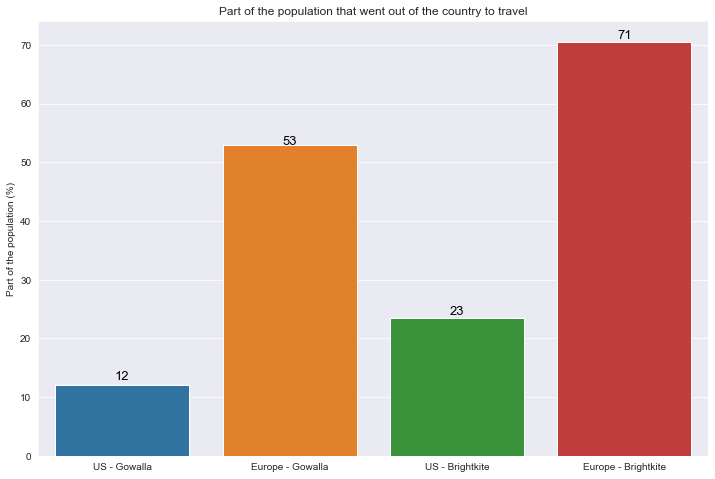

In [114]:
y=[100*gowalla_us_travel_out_of_country/gowalla_us_total, 
   100*gowalla_eu_travel_out_of_country/gowalla_eu_total,
   100*brightkite_us_travel_out_of_country/brightkite_us_total,
   100*brightkite_eu_travel_out_of_country/brightkite_eu_total]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set(title='Part of the population that went out of the country to travel', ylabel = 'Part of the population (%)')
fig.text(0, 13, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 53, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 24, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 71, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("part_of_pop_out_eu_vs_us.png")

## 2-bis Part of people who leave their continent when travelling

In [95]:
gowalla_far_checkins = pd.merge(gowalla_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_checkin', right_on = 'country')
gowalla_far_checkins.drop(columns = ['country'], inplace = True)
gowalla_far_checkins.rename(columns = {'continent':'continent_checkin'}, inplace = True)
gowalla_far_checkins.sample(5)

,user,time,lat,lon,country_checkin,home_lat,home_lon,country_home,distance_from_home,continent_home,continent_checkin
773211,108667,2010-10-14 22:15:58+00:00,17.065594,-96.724839,mexico,48.793180,9.172903,germany,9699.862556,europe,north america
910081,154700,2010-08-01 02:07:34+00:00,37.654023,-104.793231,united states,31.057034,-97.511140,united states,991.756839,north america,north america
864785,132093,2010-09-24 18:17:36+00:00,59.936301,16.962222,sweden,56.677699,12.849785,sweden,434.569649,europe,europe
652585,66619,2010-04-10 16:38:03+00:00,40.755021,-73.983211,united states,42.452616,-76.498664,united states,281.713130,north america,north america
834689,123965,2010-09-16 19:23:02+00:00,36.106624,-115.167683,united states,32.833620,-96.769878,united states,1722.550726,north america,north america


In [102]:
brightkite_far_checkins = pd.merge(brightkite_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_checkin', right_on = 'country')
brightkite_far_checkins.drop(columns = ['country'], inplace = True)
brightkite_far_checkins.rename(columns = {'continent':'continent_checkin'}, inplace = True)
brightkite_far_checkins.sample(5)

,user,time,lat,lon,country_checkin,home_lat,home_lon,country_home,distance_from_home,continent_home,continent_checkin
48249,705,2010-01-23 00:43:27+00:00,37.866866,-122.268531,united states,33.986699,-118.441171,united states,552.075392,north america,north america
294497,9649,2009-01-29 16:54:54+00:00,37.774929,-122.419415,united states,48.792447,9.181175,germany,9272.483096,europe,north america
224520,6948,2009-07-28 18:25:34+00:00,34.339793,-118.508357,united states,35.203687,-120.709511,united states,222.813377,north america,north america
17758,115,2008-10-18 03:36:12+00:00,40.459208,-90.671797,united states,39.975505,-105.194685,united states,1232.899530,north america,north america
89682,1877,2009-08-08 05:22:39+00:00,40.218245,140.261101,japan,37.914077,139.087487,japan,275.511654,asia,asia


In [106]:
gowalla_us_travel_out_of_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_checkin != gowalla_far_checkins.continent_home) & (gowalla_far_checkins.continent_home == 'north america')].user.nunique()
gowalla_us_total_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'north america')].user.nunique()
print('Part of the North America population going out of the continent to travel:',100*gowalla_us_travel_out_of_continent/gowalla_us_total_continent,'% (Gowalla)')

Part of the North America population going out of the continent to travel: 7.996139548184158 % (Gowalla)


In [107]:
gowalla_eu_travel_out_of_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_checkin != gowalla_far_checkins.continent_home) & (gowalla_far_checkins.continent_home == 'europe')].user.nunique()
gowalla_eu_total_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'europe')].user.nunique()
print('Part of the European population going out of the continent to travel:',100*gowalla_eu_travel_out_of_continent/gowalla_eu_total_continent,'% (Gowalla)')

Part of the European population going out of the continent to travel: 16.61443700021612 % (Gowalla)


In [108]:
brightkite_us_travel_out_of_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_checkin != brightkite_far_checkins.continent_home) & (brightkite_far_checkins.continent_home == 'north america')].user.nunique()
brightkite_us_total_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'north america')].user.nunique()
print('Part of the North America population going out of the continent to travel:',100*brightkite_us_travel_out_of_continent/brightkite_us_total_continent,'% (Brightkite)')

Part of the North America population going out of the continent to travel: 18.1003861003861 % (Brightkite)


In [109]:
brightkite_eu_travel_out_of_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_checkin != brightkite_far_checkins.continent_home) & (brightkite_far_checkins.continent_home == 'europe')].user.nunique()
brightkite_eu_total_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'europe')].user.nunique()
print('Part of the North America population going out of the continent to travel:',100*brightkite_eu_travel_out_of_continent/brightkite_eu_total_continent,'% (Brightkite)')

Part of the North America population going out of the continent to travel: 37.06070287539936 % (Brightkite)


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


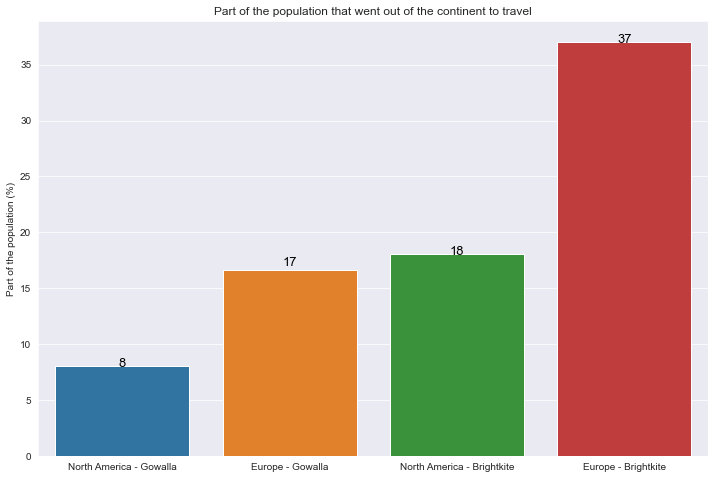

In [122]:
y=[100*gowalla_us_travel_out_of_continent/gowalla_us_total_continent, 
   100*gowalla_eu_travel_out_of_continent/gowalla_eu_total_continent,
   100*brightkite_us_travel_out_of_continent/brightkite_us_total_continent,
   100*brightkite_eu_travel_out_of_continent/brightkite_eu_total_continent]

x=['North America - Gowalla', 'Europe - Gowalla', 'North America - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set(title='Part of the population that went out of the continent to travel', ylabel = 'Part of the population (%)')
fig.text(0, 8, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 17, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 18, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 37, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("part_of_pop_out_continent_eu_vs_us.png")

## 3. Average number of visited countries per traveller

In [116]:
gowalla_us_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.country_home == 'united states')].user.nunique()
gowalla_us_number_visited_contries = gowalla_trips_full[gowalla_trips_full.country_home == 'united states'].user.sum()
print('Average number of visited countries per US traveller:', gowalla_us_number_visited_contries/gowalla_us_travel_out_of_country,'(Gowalla)')

Average number of visited countries per US traveller: 1.9387247278382582 (Gowalla)


In [117]:
brightkite_us_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.country_home == 'united states')].user.nunique()
brightkite_us_number_visited_contries = brightkite_trips_full[brightkite_trips_full.country_home == 'united states'].user.sum()
print('Average number of visited countries per US traveller:', brightkite_us_number_visited_contries/brightkite_us_travel_out_of_country,'(Brightkite)')

Average number of visited countries per US traveller: 2.200618344211611 (Brightkite)


In [118]:
gowalla_eur_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.continent_home == 'europe')].user.nunique()
gowalla_eur_number_visited_contries = gowalla_trips_full[gowalla_trips_full.continent_home == 'europe'].user.sum()
print('Average number of visited countries per European traveller:', gowalla_eur_number_visited_contries/gowalla_eur_travel_out_of_country,'(Gowalla)')

Average number of visited countries per European traveller: 1.9528907922912206 (Gowalla)


In [119]:
brightkite_eur_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.continent_home == 'europe')].user.nunique()
brightkite_eur_number_visited_contries = brightkite_trips_full[brightkite_trips_full.continent_home == 'europe'].user.sum()
print('Average number of visited countries per European traveller:', brightkite_eur_number_visited_contries/brightkite_eur_travel_out_of_country,'(Brightkite)')

Average number of visited countries per European traveller: 2.58307210031348 (Brightkite)


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


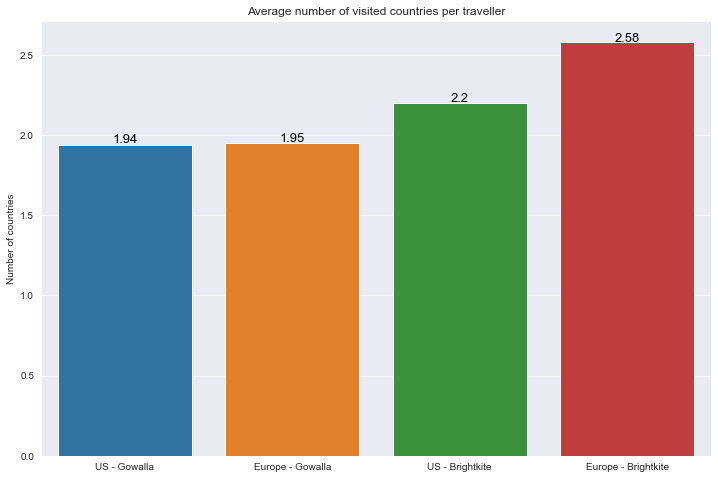

In [120]:
y=[gowalla_us_number_visited_contries/gowalla_us_travel_out_of_country, 
   gowalla_eur_number_visited_contries/gowalla_eur_travel_out_of_country,
   brightkite_us_number_visited_contries/brightkite_us_travel_out_of_country,
   brightkite_eur_number_visited_contries/brightkite_eur_travel_out_of_country]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set(title='Average number of visited countries per traveller', ylabel = 'Number of countries')
fig.text(0, 1.95, s = round(y[0], 2), color='black', ha="center", fontsize = 13)
fig.text(1, 1.96, s = round(y[1], 2), color='black', ha="center", fontsize = 13)
fig.text(2, 2.21, s = round(y[2], 2), color='black', ha="center", fontsize = 13)
fig.text(3, 2.58, s = round(y[3], 2), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("countries_per_traveller_eu_vs_us.png")

# Visualization 

In [ ]:
import folium
def make_map_with_markers(data, factor):
    # Function outputting a world map in html format with the markers place at the
    # lattitude and longitudes indicated in the corresponding columns in data.
    # Inputs:
    # - data: dataframe with 3 columns and as many rows as number of markers
    #         to place, the columns are:
    #        - longitude (['lon']): longitude of the center of the marker
    #        - lattitude (['lat']): latitude of the center of the marker
    #        - value (['value']): number proprtional to the radius of the marker, it
    #                             should be between 0 and 100.
    #         
    m = folium.Map(location=[20,0], zoom_start=2)

    # I can add marker one by one on the map
    for i in range(0,len(data)):
       folium.Circle(
          location=[data.iloc[i]['latitude'], data.iloc[i]['longitude']],
          radius=float(data.iloc[i]['count_normalized']*factor),
          color='crimson',
          fill=True,
          fill_color='crimson').add_to(m)

    # Save it as html
    #m.save('mymap.html')
    return m

In [ ]:
CENTROIDS = DATA_FOLDER+"centroids.xlsx"
centroids= pd.read_excel(CENTROIDS)

In [ ]:
centroids=centroids.drop('country',axis=1)
centroids['name']=centroids.name.str.lower()
centroids.head()

In [ ]:
b_countries_graph=brightkite_countries.merge(centroids, left_on='country', right_on='name').drop('name',axis=1)
b_countries_graph.sort_values('count_normalized',ascending=False).head(10)

In [ ]:
m=make_map_with_markers(b_countries_graph, 3*10**9)
m

In [ ]:
g_countries_graph=gowalla_countries.merge(centroids, left_on='country', right_on='name').drop('name',axis=1)
g_countries_graph.sort_values('count_normalized',ascending=False).head(10)

In [ ]:
m=make_map_with_markers(g_countries_graph,4*10**8)
m

In [ ]:
#To visualize all users' homes in the world
v=np.ones(len(brightkite_home_locations))
brightkite_home_locations['count_normalized']=v.tolist()
brightkite_home_locations.rename(columns = {'lat':'latitude','lon':'longitude'}, inplace = True)

In [ ]:
m=make_map_with_markers(brightkite_home_locations,40000)
m.save('mymap.html')

## Step 3 :  total trips between countries

In [ ]:
def not_home_country(row):
    '''return 1 if the user is in another country than his home and 0 if not'''
    country = row['country_checkin']
    home_country = row['country_home']
    if(country != home_country):
        return(1)
    else:
        return(0)

In [ ]:
brightkite_far_checkins['not_home_country'] = brightkite_far_checkins.apply(lambda row: not_home_country(row), axis = 1)
gowalla_far_checkins['not_home_country'] = gowalla_far_checkins.apply(lambda row: not_home_country(row), axis = 1)

In [ ]:
brightkite_trips = brightkite_far_checkins[(brightkite_far_checkins.change_arrival_country == 1) & (brightkite_far_checkins.not_home_country == 1)]
country_brightkite_trips = brightkite_trips[['country_home', 'country_checkin', 'user']].groupby(['country_home', 'country_checkin']).count()
country_brightkite_trips.to_csv('country_brightkite_trips.csv')

In [ ]:
gowalla_trips = gowalla_far_checkins[(gowalla_far_checkins.change_arrival_country == 1) & (gowalla_far_checkins.not_home_country == 1)]
country_gowalla_trips = gowalla_trips[['country_home', 'country_checkin', 'user']].groupby(['country_home', 'country_checkin']).count()
country_gowalla_trips.to_csv('country_gowalla_trips.csv')

In [ ]:
selected_countries = list(countries['country'])
def selected_country(row):
    '''return 1 if the user home country is well represented and 0 if not'''
    
    country = row['country_home']
    if country in selected_countries:
        return(1)
    else:
        return(0)

In [ ]:
testG = country_gowalla_trips.reset_index(drop = True)
testG['selected_country'] = testG.apply(lambda row: selected_country(row), axis = 1)
testG = testG[testG['selected_country'] == 1]
testB = country_brightkite_trips.reset_index(drop = True)
testB['selected_country'] = testB.apply(lambda row: selected_country(row), axis = 1)
testG = testG[testG['selected_country'] == 1]

In [ ]:
import networkx as nx

In [ ]:
G = nx.DiGraph()
edgesG = []
for i in range(len(testG)):
    edgesG += [(testG.iat[i, 0].split(',')[0], testG.iat[i, 1].split(',')[0], testG.iat[i, 2])]
G.add_weighted_edges_from(edgesG)

In [ ]:
B = nx.DiGraph()
edgesB = []
weights = []
for i in range(len(testB)):
    edgesB += [(testB.iat[i, 0].split(',')[0], testB.iat[i, 1].split(',')[0], testB.iat[i, 2])]
B.add_weighted_edges_from(edgesB)

In [ ]:
nx.write_weighted_edgelist(G, 'GowallaTrips.edgelist', delimiter = ',')

In [ ]:
nx.write_weighted_edgelist(B, 'BrightkiteTrips.edgelist', delimiter = ',')

In [ ]:
H = nx.read_weighted_edgelist('GowallaTrips.edgelist', delimiter = ',', create_using=nx.DiGraph())
H.edges(data = True)

In [ ]:
edge_width = [H[u][v]['weight'] for u, v in H.edges()] 
nx.draw_networkx(H,  width = edge_width)

In [ ]:
#selecting the biggest flows
bigG = country_gowalla_trips[country_gowalla_trips['user']>200]
G2 = nx.DiGraph()
edgesG2 = []
for i in range(len(bigG)):
    edgesG += [(bigG.iat[i, 0].split(',')[0], bigG.iat[i, 1].split(',')[0], bigG.iat[i, 2])]
G2.add_weighted_edges_from(edgesG2)
edge_width = [G2[u][v]['weight'] for u, v in G2.edges()] 
nx.draw_networkx(G2,  width = edge_width)